# 中英翻译任务

从这里找到了一个数据集

- https://www.heywhale.com/mw/dataset/60c41b7a19d601001898b34a

打算用刚学的transformer来做一个翻译任务

## 数据简单说明

- 实验数据集为 [WMT18 新闻评论数据集 News Commentary v13](https://www.statmt.org/wmt18/translation-task.html)，
  - 整个语料库分训练集（约 252,700 条）、
  - 验证集和测试集（分别约 2,000 条）三部分，
  - 每部分包含中英文平行语料两个文件，
  - 全部语料已预分词处理；

## 数据处理

### Load data

In [1]:
import os
# 个人理解下面这两个可以互换

def read_en_train(data_dir = "./wnt_cn_en/data/train"):
    """载入英文数据集"""
    with open(os.path.join(data_dir, 'news-commentary-v13.zh-en.en'), 'r',
             encoding='utf-8') as f:
        return f.read()
    
def read_cn_train(data_dir = "./wnt_cn_en/data/train"):
    """载入中文数据集"""
    with open(os.path.join(data_dir, 'news-commentary-v13.zh-en.zh'), 'r',
             encoding='utf-8') as f:
        return f.read()

In [2]:
en_train = read_en_train()
cn_train = read_cn_train()

In [3]:
en_train[:100]

'1929 or 1989?\nPARIS – As the economic crisis deepens and widens, the world has been searching for hi'

In [4]:
cn_train[:100]

'1929 年 还是 1989 年 ?\n巴黎 - 随着 经济危机 不断 加深 和 蔓延 ， 整个 世界 一直 在 寻找 历史 上 的 类似 事件 希望 有助于 我们 了解 目前 正在 发生 的 情况 。'

### Preprocess

因为已经做过分词处理，所以不需要再做分词处理了；而且基本符号前面都有空格分开，使我们的处理更加方便；

In [5]:
len(en_train.split('\n')), len(cn_train.split('\n'))

(252778, 252778)

In [9]:
def preprocess(text):
    """
    预处理数据集

    Parameters
    ----------
    @param text: str
        the text to be processed
    @return: str
        processed text
    """
    def add_space(char, prev_char, next_char):
        return char in set('(),.!?') and prev_char != ' ' and next_char != ' '

    # 使用空格替换不间断空格
    # 使用小写字母替换大写字母
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # 在单词和标点符号之间插入空格
    out = [' ' + char + ' ' if i > 0 and i < len(text) - 1 and add_space(char, text[i - 1], text[i + 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

In [12]:
en_train = preprocess(en_train)
cn_train = preprocess(cn_train)

### Tokenize

In [13]:
def tokenize(text, num_examples=None):
    """
    词元化

    Parameters
    ----------
    @param text: str
        The text to tokenize
    @param num_examples: int
        The number of examples in the dataset
    """
    tokens = []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        if line:
            tokens.append(line.split(' '))
    return tokens

In [14]:
en_tokens = tokenize(en_train)
cn_tokens = tokenize(cn_train)
en_tokens[:3], cn_tokens[:3]

([['1929', 'or', '1989', '?'],
  ['paris',
   '–',
   'as',
   'the',
   'economic',
   'crisis',
   'deepens',
   'and',
   'widens',
   ',',
   'the',
   'world',
   'has',
   'been',
   'searching',
   'for',
   'historical',
   'analogies',
   'to',
   'help',
   'us',
   'understand',
   'what',
   'has',
   'been',
   'happening',
   '.'],
  ['at',
   'the',
   'start',
   'of',
   'the',
   'crisis',
   ',',
   'many',
   'people',
   'likened',
   'it',
   'to',
   '1982',
   'or',
   '1973',
   ',',
   'which',
   'was',
   'reassuring',
   ',',
   'because',
   'both',
   'dates',
   'refer',
   'to',
   'classical',
   'cyclical',
   'downturns',
   '.']],
 [['1929', '年', '还是', '1989', '年', '?'],
  ['巴黎',
   '-',
   '随着',
   '经济危机',
   '不断',
   '加深',
   '和',
   '蔓延',
   '，',
   '整个',
   '世界',
   '一直',
   '在',
   '寻找',
   '历史',
   '上',
   '的',
   '类似',
   '事件',
   '希望',
   '有助于',
   '我们',
   '了解',
   '目前',
   '正在',
   '发生',
   '的',
   '情况',
   '。'],
  ['一',
   '开始',
   '，',
 

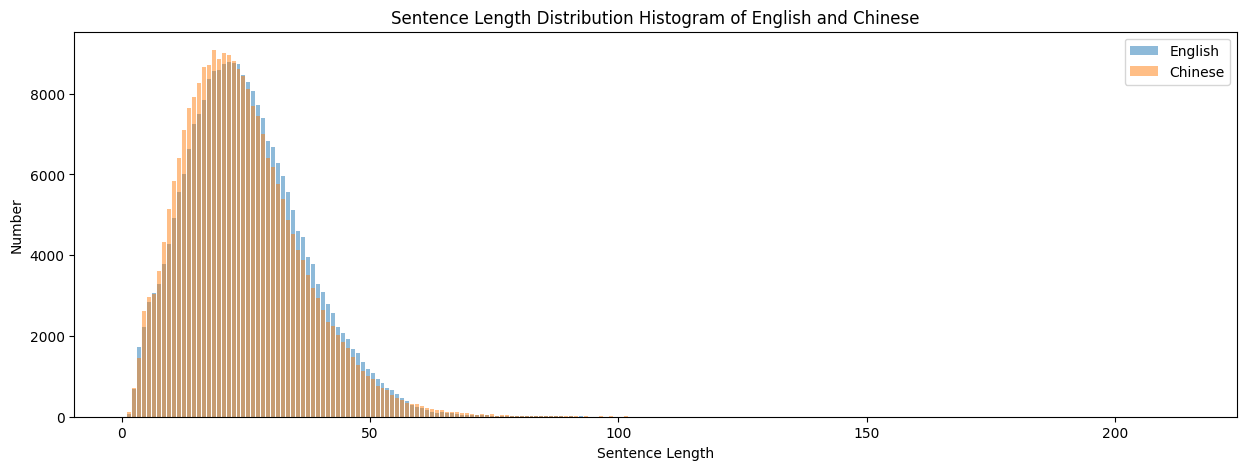

In [15]:
import matplotlib.pyplot as plt

def plot_length(en_tokens, cn_tokens):
    """绘制英文和中文句子长度分布图"""
    en_len = [len(t) for t in en_tokens]
    cn_len = [len(t) for t in cn_tokens]
    plt.hist(en_len, bins=range(min(en_len), max(en_len)+1), label='English', alpha=0.5, rwidth=0.8)
    plt.hist(cn_len, bins=range(min(cn_len), max(cn_len)+1), label='Chinese', alpha=0.5, rwidth=0.8)
    plt.legend()
    plt.title('Sentence Length Distribution Histogram of English and Chinese')
    plt.xlabel('Sentence Length')
    plt.ylabel('Number')
    plt.show()

plt.figure(figsize=(15, 5))
plot_length(en_tokens, cn_tokens)

### Vocabulary

In [16]:
import collections

class Vocab:
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        """
        Vocabulary for text.
        
        Parameters
        ----------
        @param tokens: list of token lists
        @param min_freq: int
            The minimum frequency required for a token to be included in the vocabulary
        @param reserved_tokens: list of str
            The token list that will be added to the vocabulary
        """
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self._token_freqs = sorted(
            counter.items(),
            key=lambda x: x[1],
            reverse=True
        )
        # The index for the unknown token is 0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # Index for the unknown token
        return 0

    @property
    def token_freqs(self): 
        return self._token_freqs

def count_corpus(tokens):
    """
    Count token frequencies.
    
    Parameters
    ----------
    @param tokens: list of token lists
    @return: `collections.Counter` instance that maps tokens to frequencies
    """
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [17]:
en_vocab = Vocab(en_tokens, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
cn_vocab = Vocab(cn_tokens, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(en_vocab), len(cn_vocab)

(52392, 54692)

In [19]:
# Print the first 10 tokens and their indices
print(list(en_vocab.token_to_idx.items())[:15])
print(list(cn_vocab.token_to_idx.items())[:15])

[('<unk>', 0), ('<pad>', 1), ('<bos>', 2), ('<eos>', 3), ('the', 4), (',', 5), ('.', 6), ('of', 7), ('to', 8), ('and', 9), ('in', 10), ('a', 11), ('that', 12), ('is', 13), ('for', 14)]
[('<unk>', 0), ('<pad>', 1), ('<bos>', 2), ('<eos>', 3), ('的', 4), ('，', 5), ('。', 6), ('在', 7), ('和', 8), ('', 9), ('是', 10), ('了', 11), ('、', 12), ('也', 13), ('但', 14)]


### Take a grasp of the process

In [12]:
cn_sample = cn_train.split('\n')[4]
en_sample = en_train.split('\n')[4]
print(f"Chinese raw: {cn_sample}")
print(f"English raw: {en_sample}")
cn_sample_tokens = tokenize(cn_sample)
en_sample_tokens = tokenize(en_sample)
print(f"Chinese tokens: {cn_sample_tokens}")
print(f"English tokens: {en_sample_tokens}")
print(f"Cninese indices: {cn_vocab[cn_sample_tokens]}")
print(f"English indices: {en_vocab[en_sample_tokens]}")

Chinese raw: 目前 的 趋势 是 ， 要么 是 过度 的 克制 （ 欧洲 ）， 要么 是 努力 的 扩展 （ 美国 ）。
English raw: The tendency is either excessive restraint (Europe) or a diffusion of the effort (the United States).
Chinese tokens: [['目前', '的', '趋势', '是', '，', '要么', '是', '过度', '的', '克制', '（', '欧洲', '），', '要么', '是', '努力', '的', '扩展', '（', '美国', '）。']]
English tokens: [['The', 'tendency', 'is', 'either', 'excessive', 'restraint', '(Europe)', 'or', 'a', 'diffusion', 'of', 'the', 'effort', '(the', 'United', 'States).']]
Cninese indices: [[204, 4, 714, 10, 5, 1126, 10, 697, 4, 4194, 20, 50, 279, 1126, 10, 436, 4, 3022, 20, 17, 237]]
English indices: [[15, 3872, 11, 709, 1112, 7485, 50593, 33, 9, 8131, 5, 4, 584, 910, 92, 31937]]


### Load dataset

In [13]:
#@save
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    if len(line) > num_steps:
        return line[:num_steps]  # 截断
    return line + [padding_token] * (num_steps - len(line))  # 填充

In [14]:
print(f"num_steps=10, padding_token=0, line={cn_vocab[cn_sample_tokens[0]]}")
print(f"after truncate_pad: {truncate_pad(cn_vocab[cn_sample_tokens[0]], 10, cn_vocab['<pad>'])}")
print(f"num_steps=30, padding_token=0, line={cn_vocab[cn_sample_tokens[0]]}")
print(f"after truncate_pad: {truncate_pad(cn_vocab[cn_sample_tokens[0]], 30, cn_vocab['<pad>'])}")

num_steps=10, padding_token=0, line=[204, 4, 714, 10, 5, 1126, 10, 697, 4, 4194, 20, 50, 279, 1126, 10, 436, 4, 3022, 20, 17, 237]
after truncate_pad: [204, 4, 714, 10, 5, 1126, 10, 697, 4, 4194]
num_steps=30, padding_token=0, line=[204, 4, 714, 10, 5, 1126, 10, 697, 4, 4194, 20, 50, 279, 1126, 10, 436, 4, 3022, 20, 17, 237]
after truncate_pad: [204, 4, 714, 10, 5, 1126, 10, 697, 4, 4194, 20, 50, 279, 1126, 10, 436, 4, 3022, 20, 17, 237, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [15]:
import torch
from torch import nn

def build_array(tokens, vocab, num_steps):
    """
    将文本序列转换成向量
    
    Parameters
    ----------
    @param tokens: list of token lists
        2D list 
    @param vocab: instance of Vocab
    @param num_steps: int
        The length of the sequence of tokens in a batch
    @return: torch.Tensor
        2D tensor with shape (batch size, num_steps)
    """
    tokens = [vocab[token_line] for token_line in tokens]
    tokens = [token_line + [vocab['<eos>']] for token_line in tokens]
    array = torch.tensor([
        truncate_pad(
            line=token_line, 
            num_steps=num_steps, 
            padding_token=vocab['<pad>']
        ) for token_line in tokens
    ])
    valid_len = (array != vocab['<pad>']).sum(1)
    return array, valid_len

In [16]:
def load_data_train(batch_size, num_steps, num_examples = 600):
    """
    返回数据迭代器和词汇表

    Parameters
    ----------
    @param batch_size: int
    @param num_steps: int
        The length of the sequence of tokens in a batch
    @param num_examples: int
        The number of examples in the dataset
    @return: tuple of (data_iter, en_vocab, cn_vocab)
        - data_iter: instance of torch.utils.data.DataLoader
        - en_vocab: instance of Vocab for English
        - cn_vocab: instance of Vocab for Chinese
    """
    en_train = read_en_train()
    cn_train = read_cn_train()
    en_tokens = tokenize(en_train, num_examples)
    cn_tokens = tokenize(cn_train, num_examples)
    en_vocab = Vocab(en_tokens, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    cn_vocab = Vocab(cn_tokens, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    en_array, en_valid_len = build_array(en_tokens, en_vocab, num_steps)
    cn_array, cn_valid_len = build_array(cn_tokens, cn_vocab, num_steps)
    dataset = torch.utils.data.TensorDataset(en_array, en_valid_len, cn_array, cn_valid_len)
    data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    return data_iter, en_vocab, cn_vocab

In [17]:
train_iter, en_vocab, cn_vocab = load_data_train(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.type(torch.int32))
    print('valid lengths for X:', X_valid_len)
    print('Y:', Y.type(torch.int32))
    print('valid lengths for Y:', Y_valid_len)
    break

X: tensor([[ 583,  242,  129,    0,   97,  907,    0,    3],
        [   0, 1158,   21,    0,    9,  943,   16,  468]], dtype=torch.int32)
valid lengths for X: tensor([8, 8])
Y: tensor([[  51,   76,   14,  545,    0,    5,  216,   42],
        [   0,   18,    0,  627, 1272,    6,    3,    1]], dtype=torch.int32)
valid lengths for Y: tensor([8, 7])


In [18]:
en_vocab.to_tokens(X[0].numpy().tolist()), cn_vocab.to_tokens(Y[0].numpy().tolist())

(['All', 'things', 'being', '<unk>', 'we', 'probably', '<unk>', '<eos>'],
 ['”', '如果', '将', '一切', '<unk>', '，', '那', '我们'])

## 小结

至此，我们已经完成了数据的读取，下一步就是利用模型来训练了；